# Simple decision rules give high performance for detecting social bots on benchmark datasets

Analysis of benchmark datasets for bot detection.

## Setup

In [ ]:
import bson
import datetime
import itertools
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.ticker import MaxNLocator
import pandas as pd
import pyreadr
import random
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score
from sklearn import tree, ensemble
import sys
import time
import importlib


In [1408]:
importlib.reload(sys.modules['data_accessor'])

from data_accessor import load_twibot, load_bot_repo_dataset, load_cresci, load_cresci2017, load_cresci2015, load_caverlee, load_emd, load_pan19, load_cresci2017_tweets, load_cresci2015_tweets, load_midterm, load_gilani_derived_bands, load_yang, load_yang_tweets, load_cresci_stock_tweets, tweets_to_countvectorized_df
from preprocess import drop_and_one_hot, extract_users, load_json, preprocess_users, COLUMNS_TO_DROP, DUMMY_COLUMNS
from fit_and_score import fit, score, fit_and_score, kfold_cv, analyze_bot_repo_dataset, analyze_bot_repo_dataset_full, train_test_fit_and_score, train_test_fit_and_score_clf, nonnumeric, mdi_feature_importance, permutation_feature_importance, plot_metrics, calculate_accuracy
from unused_data import remove_trailing_zero


In [586]:
PROJ_PATH = "/nfs/sloanlab003/projects/bot_ensemble_proj/bot-detection"

def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]

def get_dataset_name(df):
    try:
        return namestr(df, globals())[0]
    except:
        return "Unknown"


## Load datasets and calculate scores

## Profile data

In [1287]:
# Twibot
twibot_df, twibot_2020_one_hot, twibot_labels = load_twibot(PROJ_PATH + "/data/Twibot-20/train.json")
twibot_test, twibot_2020_one_hot_test, twibot_labels_test = load_twibot(PROJ_PATH + "/data/Twibot-20/test.json")
#twibot_validate, twibot_2020_one_hot_validate, twibot_labels_validate = load_twibot(PROJ_PATH + "/data/Twibot-20/dev.json")
shared_columns = set.intersection(set(twibot_2020_one_hot.columns), set(twibot_2020_one_hot_test.columns)) # Since we want to check on test set, just use common columns between train/test.
twibot_scores = []
for i in range(1, 6):
    dt_clf = fit(twibot_2020_one_hot[shared_columns], twibot_labels, depth=i)
    scr = score(dt_clf, twibot_2020_one_hot_test[shared_columns], twibot_labels_test, silent=True)
    # balanced
    baccs = []
    iters = 5
    for j in range(iters):
        twibot_2020_humans = twibot_2020_one_hot[pd.Series(twibot_labels) == 0]
        twibot_2020_bots = twibot_2020_one_hot[pd.Series(twibot_labels) == 1]
        n_accts = min(len(twibot_2020_humans), len(twibot_2020_bots))
        btwibot_labels = [0]*n_accts + [1]*n_accts
        bal_clf = fit(pd.concat([twibot_2020_humans.sample(n_accts), twibot_2020_bots.sample(n_accts)])[shared_columns], btwibot_labels, depth=i)
        twibot_2020_humans_test = twibot_2020_one_hot[pd.Series(twibot_labels) == 0]
        twibot_2020_bots_test = twibot_2020_one_hot[pd.Series(twibot_labels) == 1]
        n_accts_test = min(len(twibot_2020_humans_test), len(twibot_2020_bots_test))
        btwibot_labels_test = [0]*n_accts_test + [1]*n_accts_test
        bacc, *_ = score(bal_clf, pd.concat([twibot_2020_humans_test.sample(n_accts_test), twibot_2020_bots_test.sample(n_accts_test)])[shared_columns], btwibot_labels_test, silent=True)
        baccs = baccs + [bacc]
    mean_bacc = sum(baccs)/iters
    twibot_scores.append(list(scr) + [mean_bacc])
    

In [1382]:
# botometer-feedback
bf, botometer_feedback_2019_one_hot, bf_labels = load_bot_repo_dataset(PROJ_PATH + "/data/botometer-feedback-2019_tweets.json", PROJ_PATH + "/data/botometer-feedback-2019.tsv")
botometer_feedback_scores = analyze_bot_repo_dataset(botometer_feedback_2019_one_hot, bf_labels, silent=True)

Starting kfold_cv at 10/07/22 15:47:17
Finished kfold_cv at 1665172037.5428152. Execution time: 0.11285829544067383 s
Starting kfold_cv at 10/07/22 15:47:17
Finished kfold_cv at 1665172037.631188. Execution time: 0.0882866382598877 s
Starting kfold_cv at 10/07/22 15:47:17
Finished kfold_cv at 1665172037.721704. Execution time: 0.09042239189147949 s
Starting kfold_cv at 10/07/22 15:47:17
Finished kfold_cv at 1665172037.8225932. Execution time: 0.10079145431518555 s
Starting kfold_cv at 10/07/22 15:47:17
Finished kfold_cv at 1665172037.9195182. Execution time: 0.09683680534362793 s
Starting kfold_cv at 10/07/22 15:47:17
Finished kfold_cv at 1665172038.0038977. Execution time: 0.08427214622497559 s
Starting kfold_cv at 10/07/22 15:47:18
Finished kfold_cv at 1665172038.0875986. Execution time: 0.0836031436920166 s
Starting kfold_cv at 10/07/22 15:47:18
Finished kfold_cv at 1665172038.1739025. Execution time: 0.0862126350402832 s
Starting kfold_cv at 10/07/22 15:47:18
Finished kfold_cv at 1

In [1384]:
# botometer-feedback
bf, botometer_feedback_2019_one_hot, bf_labels = load_bot_repo_dataset(PROJ_PATH + "/data/botometer-feedback-2019_tweets.json", PROJ_PATH + "/data/botometer-feedback-2019.tsv")
botometer_feedback_scores = analyze_bot_repo_dataset(botometer_feedback_2019_one_hot, bf_labels, silent=True)

#rtbust
rtbust, cresci_rtbust_2019_one_hot, rtbust_labels = load_bot_repo_dataset(PROJ_PATH + "/data/cresci-rtbust-2019_tweets.json", PROJ_PATH + "/data/cresci-rtbust-2019.tsv")
rtbust_scores = analyze_bot_repo_dataset(cresci_rtbust_2019_one_hot, rtbust_labels, silent=True)

#gilani-2017
gilani, gilani_2017_one_hot, gilani_labels = load_bot_repo_dataset(PROJ_PATH + "/data/gilani-2017_tweets.json", PROJ_PATH + "/data/gilani-2017.tsv")
gilani_scores = analyze_bot_repo_dataset(gilani_2017_one_hot, gilani_labels, silent=True)

#gilani-2017 with derived features from orginal paper
gilani_derived_dfs, gilani_derived_labels = load_gilani_derived_bands(PROJ_PATH + f"/data/gilani_derived/classification_processed/")
gilani_derived_scores = [analyze_bot_repo_dataset(gilani_derived_df, gilani_derived_label, silent=True) for gilani_derived_df, gilani_derived_label in zip(gilani_derived_dfs, gilani_derived_labels)]
gilani_derived_scores_avg = [[sum([strat[depth_ind][scr_ind] for strat in gilani_derived_scores])/4 for scr_ind in range(4)] for depth_ind in range(5)]

#cresci-2017
cresci2017, cresci_2017_one_hot, cresci2017_labels = load_cresci2017(PROJ_PATH + "/data/cresci-2017/{}.csv/users.csv")
cresci2017_scores = analyze_bot_repo_dataset(cresci_2017_one_hot, cresci2017_labels, silent=True)

#cresci-2015
cresci2015, cresci_2015_one_hot, cresci2015_labels = load_cresci2015(PROJ_PATH + "/data/cresci-2015/{}/users.csv")
cresci2015_scores = analyze_bot_repo_dataset(cresci_2015_one_hot, cresci2015_labels, silent=True)

#caverlee-2011
caverlee_2011, caverlee_2011_labels = load_caverlee(PROJ_PATH + "/data/social_honeypot_icwsm_2011/")
caverlee_2011_scores = analyze_bot_repo_dataset(caverlee_2011, caverlee_2011_labels, silent=True)

#cresci-stock-2018
cresci_stock, cresci_stock_2018_one_hot, cresci_stock_labels = load_bot_repo_dataset(PROJ_PATH + "/data/cresci-stock-2018_tweets.json", PROJ_PATH + "/data/cresci-stock-2018.tsv")
cresci_stock_scores = analyze_bot_repo_dataset(cresci_stock_2018_one_hot, cresci_stock_labels, silent=True)


Starting kfold_cv at 10/07/22 15:47:43
Finished kfold_cv at 1665172063.2065978. Execution time: 0.10977339744567871 s
Starting kfold_cv at 10/07/22 15:47:43
Finished kfold_cv at 1665172063.2949648. Execution time: 0.08828091621398926 s
Starting kfold_cv at 10/07/22 15:47:43
Finished kfold_cv at 1665172063.386158. Execution time: 0.09111380577087402 s
Starting kfold_cv at 10/07/22 15:47:43
Finished kfold_cv at 1665172063.4800096. Execution time: 0.09377241134643555 s
Starting kfold_cv at 10/07/22 15:47:43
Finished kfold_cv at 1665172063.5773191. Execution time: 0.09720706939697266 s
Starting kfold_cv at 10/07/22 15:47:43
Finished kfold_cv at 1665172063.6640503. Execution time: 0.08663821220397949 s
Starting kfold_cv at 10/07/22 15:47:43
Finished kfold_cv at 1665172063.7479987. Execution time: 0.08386349678039551 s
Starting kfold_cv at 10/07/22 15:47:43
Finished kfold_cv at 1665172063.83296. Execution time: 0.0848689079284668 s
Starting kfold_cv at 10/07/22 15:47:43
Finished kfold_cv at 

Starting kfold_cv at 10/07/22 15:47:51
Finished kfold_cv at 1665172075.0853748. Execution time: 3.3997609615325928 s
Starting kfold_cv at 10/07/22 15:47:55
Finished kfold_cv at 1665172079.0394192. Execution time: 3.953845500946045 s
Starting kfold_cv at 10/07/22 15:47:59
Finished kfold_cv at 1665172083.4095664. Execution time: 4.369809627532959 s
Starting kfold_cv at 10/07/22 15:48:03
Finished kfold_cv at 1665172088.132686. Execution time: 4.722923278808594 s
Starting kfold_cv at 10/07/22 15:48:08
Finished kfold_cv at 1665172093.2033992. Execution time: 5.070523262023926 s
Starting kfold_cv at 10/07/22 15:48:13
Finished kfold_cv at 1665172095.469055. Execution time: 2.265408754348755 s
Starting kfold_cv at 10/07/22 15:48:15
Finished kfold_cv at 1665172097.9366274. Execution time: 2.4673852920532227 s
Starting kfold_cv at 10/07/22 15:48:17
Finished kfold_cv at 1665172100.5253565. Execution time: 2.5884008407592773 s
Starting kfold_cv at 10/07/22 15:48:20
Finished kfold_cv at 1665172103.

In [ ]:
train_test_fit_and_score(cresci_rtbust_2019_one_hot, rtbust_labels, depth=3, balance=False)

In [1385]:
# bot-wiki
botwiki_df, botwiki_one_hot, botwiki_labels = load_bot_repo_dataset(PROJ_PATH + "/data/botwiki-2019_tweets.json", PROJ_PATH + "/data/botwiki-2019.tsv")
# celebrity
celebrity_df, celebrity_one_hot, celebrity_labels = load_bot_repo_dataset(PROJ_PATH + "/data/celebrity-2019_tweets.json", PROJ_PATH + "/data/celebrity-2019.tsv")
# political-bots
political_bots_df, political_bots_one_hot, political_bots_labels = load_bot_repo_dataset(PROJ_PATH + "/data/political-bots-2019/political-bots-2019_tweets.json", PROJ_PATH + "/data/political-bots-2019/political-bots-2019.tsv")
# pronbots
pronbots_df, pronbots_one_hot, pronbots_labels = load_bot_repo_dataset(PROJ_PATH + "/data/pronbots-2019_tweets.json", PROJ_PATH + "/data/pronbots-2019.tsv")
# vendor purchased
vendor_purchased_df, vendor_purchased_one_hot, vendor_purchased_labels = load_bot_repo_dataset(PROJ_PATH + "/data/vendor-purchased-2019_tweets.json", PROJ_PATH + "/data/vendor-purchased-2019.tsv")
#verified
verified_df, verified_one_hot, verified_labels = load_bot_repo_dataset(PROJ_PATH + "/data/verified-2019_tweets.json", PROJ_PATH + "/data/verified-2019.tsv")

# EMD
ersahin_2017, ersahin_2017_labels = load_emd(PROJ_PATH + '/data/EMD-2017/Twitter_dataset.arff') # Load data

In [1386]:
midterm, midterm_2018_one_hot, midterm_labels = load_midterm(PROJ_PATH + "/data/midterm-2018/midterm-2018_processed_user_objects.json", PROJ_PATH + "/data/midterm-2018/midterm-2018.tsv")
midterm_scores = analyze_bot_repo_dataset(midterm_2018_one_hot, midterm_labels, kfold=False, silent=True)

getting here
Starting train_test_fit_and_score_clf at 10/07/22 15:50:47
Finished train_test_fit_and_score_clf at 1665172301.8520963. Execution time: 54.14731025695801 s
Starting train_test_fit_and_score_clf at 10/07/22 15:51:41
Finished train_test_fit_and_score_clf at 1665172359.6413069. Execution time: 57.788907051086426 s
Starting train_test_fit_and_score_clf at 10/07/22 15:52:39
Finished train_test_fit_and_score_clf at 1665172421.3783252. Execution time: 61.73670053482056 s
Starting train_test_fit_and_score_clf at 10/07/22 15:53:41
Finished train_test_fit_and_score_clf at 1665172486.5683594. Execution time: 65.18972754478455 s
Starting train_test_fit_and_score_clf at 10/07/22 15:54:46
Finished train_test_fit_and_score_clf at 1665172555.7271903. Execution time: 69.1585214138031 s


In [1387]:
yang, yang_2013_one_hot, yang_labels = load_yang(PROJ_PATH + "/data/yang-2013/")
yang_scores = analyze_bot_repo_dataset(yang_2013_one_hot, yang_labels)

Starting kfold_cv at 10/07/22 15:55:57
Finished kfold_cv at 1665172577.4899294. Execution time: 20.307188749313354 s
Starting kfold_cv at 10/07/22 15:56:17
Finished kfold_cv at 1665172601.1247098. Execution time: 23.63442325592041 s
Starting kfold_cv at 10/07/22 15:56:41
Finished kfold_cv at 1665172627.5649817. Execution time: 26.43988800048828 s
Starting kfold_cv at 10/07/22 15:57:07
Finished kfold_cv at 1665172656.6762574. Execution time: 29.11090850830078 s
Starting kfold_cv at 10/07/22 15:57:36
Finished kfold_cv at 1665172687.8315983. Execution time: 31.154962301254272 s
Starting kfold_cv at 10/07/22 15:58:07
Finished kfold_cv at 1665172696.5206883. Execution time: 8.688685178756714 s
Starting kfold_cv at 10/07/22 15:58:16
Finished kfold_cv at 1665172705.0567892. Execution time: 8.535767555236816 s
Starting kfold_cv at 10/07/22 15:58:25
Finished kfold_cv at 1665172713.700738. Execution time: 8.643719673156738 s
Starting kfold_cv at 10/07/22 15:58:33
Finished kfold_cv at 1665172722.

## Tweets data

In [1388]:
yang_tweets, yang_2013_tweets_labels = load_yang_tweets(PROJ_PATH + "/data/yang-2013/")
yang_tweets_scores = analyze_bot_repo_dataset(yang_tweets, yang_2013_tweets_labels)


Starting kfold_cv at 10/07/22 16:00:12
Finished kfold_cv at 1665172834.3027408. Execution time: 22.172532081604004 s
Starting kfold_cv at 10/07/22 16:00:34
Finished kfold_cv at 1665172868.593337. Execution time: 34.29038381576538 s
Starting kfold_cv at 10/07/22 16:01:08
Finished kfold_cv at 1665172914.5048594. Execution time: 45.91113066673279 s
Starting kfold_cv at 10/07/22 16:01:54
Finished kfold_cv at 1665172971.9243326. Execution time: 57.41906762123108 s
Starting kfold_cv at 10/07/22 16:02:51
Finished kfold_cv at 1665173040.9974518. Execution time: 69.0727105140686 s
Starting kfold_cv at 10/07/22 16:04:00
Finished kfold_cv at 1665173047.8034902. Execution time: 6.805635213851929 s
Starting kfold_cv at 10/07/22 16:04:07
Finished kfold_cv at 1665173056.563499. Execution time: 8.759685516357422 s
Starting kfold_cv at 10/07/22 16:04:16
Finished kfold_cv at 1665173067.1353765. Execution time: 10.571713209152222 s
Starting kfold_cv at 10/07/22 16:04:27
Finished kfold_cv at 1665173079.05

In [1398]:
pan_2019_df, pan19_labels = load_pan19(PROJ_PATH + "/data/pan19/pan19-author-profiling-training-2019-02-18/en/{}.xml", PROJ_PATH + "/data/pan19/pan19-author-profiling-training-2019-02-18/en/truth.txt")
pan19_scores = analyze_bot_repo_dataset(pan_2019_df, pan19_labels)


Starting kfold_cv at 10/07/22 16:21:12
Finished kfold_cv at 1665174076.9866495. Execution time: 4.7592926025390625 s
Starting kfold_cv at 10/07/22 16:21:16
Finished kfold_cv at 1665174083.8426266. Execution time: 6.85580039024353 s
Starting kfold_cv at 10/07/22 16:21:23
Finished kfold_cv at 1665174092.866968. Execution time: 9.024145603179932 s
Starting kfold_cv at 10/07/22 16:21:32
Finished kfold_cv at 1665174103.742617. Execution time: 10.875348567962646 s
Starting kfold_cv at 10/07/22 16:21:43
Finished kfold_cv at 1665174116.7194612. Execution time: 12.976686000823975 s
Starting kfold_cv at 10/07/22 16:21:56
Finished kfold_cv at 1665174121.999779. Execution time: 5.2799389362335205 s
Starting kfold_cv at 10/07/22 16:22:01
Finished kfold_cv at 1665174129.27283. Execution time: 7.272893667221069 s
Starting kfold_cv at 10/07/22 16:22:09
Finished kfold_cv at 1665174138.5737078. Execution time: 9.30068850517273 s
Starting kfold_cv at 10/07/22 16:22:18
Finished kfold_cv at 1665174149.8133

In [1409]:
cresci_2017_tweets, cresci_2017_tweets_labels = load_cresci2017_tweets(PROJ_PATH + "/data/cresci-2017/{}.csv/tweets.csv")
cresci_2017_tweets_scores = analyze_bot_repo_dataset(cresci_2017_tweets, cresci_2017_tweets_labels, silent=True)


/home/jhays/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3343: DtypeWarning: Columns (8,11) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/jhays/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3343: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/jhays/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3343: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/jhays/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3343: DtypeWarning: Columns (7,10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Starting kfold_cv at 10/07/22 16:35:05
Finished kfold_cv at 1665174954.9184365. Execution time: 49.880038022994995 s
Starting kfold_cv at 10/07/22 16:35:54
Finished kfold_cv at 1665175032.371238. Execution time: 77.45242357254028 s
Starting kfold_cv at 10/07/22 16:37:12
Finished kfold_cv at 1665175135.9345758. Execution time: 103.56292271614075 s
Starting kfold_cv at 10/07/22 16:38:55
Finished kfold_cv at 1665175265.210303. Execution time: 129.27523255348206 s
Starting kfold_cv at 10/07/22 16:41:05
Finished kfold_cv at 1665175420.479958. Execution time: 155.26917791366577 s
Starting kfold_cv at 10/07/22 16:43:40
Finished kfold_cv at 1665175437.6873846. Execution time: 17.206937313079834 s
Starting kfold_cv at 10/07/22 16:43:57
Finished kfold_cv at 1665175460.7004974. Execution time: 23.012733459472656 s
Starting kfold_cv at 10/07/22 16:44:20
Finished kfold_cv at 1665175489.14071. Execution time: 28.43999147415161 s
Starting kfold_cv at 10/07/22 16:44:49
Finished kfold_cv at 1665175520.

In [1411]:
cresci_2015_tweets, cresci_2015_tweets_labels = load_cresci2015_tweets(PROJ_PATH + "/data/cresci-2015/{}/tweets.csv")
cresci_2015_tweets_scores = analyze_bot_repo_dataset(cresci_2015_tweets, cresci2015_labels)


Starting kfold_cv at 10/07/22 16:50:08
Finished kfold_cv at 1665175831.7089179. Execution time: 22.854049682617188 s
Starting kfold_cv at 10/07/22 16:50:31
Finished kfold_cv at 1665175865.8004606. Execution time: 34.09115934371948 s
Starting kfold_cv at 10/07/22 16:51:05
Finished kfold_cv at 1665175907.0361679. Execution time: 41.23519229888916 s
Starting kfold_cv at 10/07/22 16:51:47
Finished kfold_cv at 1665175951.9683146. Execution time: 44.931644439697266 s
Starting kfold_cv at 10/07/22 16:52:31
Finished kfold_cv at 1665176005.8308055. Execution time: 53.86196565628052 s
Starting kfold_cv at 10/07/22 16:53:25


IndexError: Boolean index has wrong length: 5301 instead of 5148

In [ ]:
cresci_stock_2018_tweets, cresci_stock_2018_tweets_labels = load_cresci_stock_2018_tweets(PROJ_PATH + "/data/cresci-stock-2018_tweets.json", PROJ_PATH + "/data/cresci-stock-2018.tsv", PROJ_PATH + "/data/golbeck/tweets/{}_tweets.csv")
cresci_stock_2018_tweets_scores = analyze_bot_repo_dataset(cresci_stock_2018_tweets, cresci_stock_2018_tweets_labels)


In [ ]:
scores = {
    'twibot-2020': twibot_scores, 
    'botometer-feedback-2019': botometer_feedback_scores, 
    'cresci-rtbust-2019': rtbust_scores, 
    'gilani-2017': gilani_derived_scores_avg, 
    'cresci-2017': cresci2017_scores, 
    'cresci-2015': cresci2015_scores, 
    'caverlee-2011': caverlee_2011_scores,
    'midterm-2018': midterm_scores, 
    'yang-2013': yang_scores,
    'cresci-stock-2018': cresci_stock_scores,
    'pan-2019': pan19_scores
}

rows = []

for name, scr in scores.items():
    row = {'name': name}
    for i, (a,p,r,f,ba) in enumerate(scr):
        row.update({
            f'a{i+1}': a,
            f'p{i+1}': p,
            f'r{i+1}': r,
            f'f{i+1}': f,
            f'ba{i+1}': ba
        })
    rows.append(row)
scores_df = pd.DataFrame(rows)
scores_df.to_csv("scores.csv", index=False)

# Train on one, test on another

In [526]:
datasets = [twibot_2020_one_hot, botometer_feedback_2019_one_hot, cresci_rtbust_2019_one_hot, gilani_2017_one_hot, cresci_2017_one_hot, cresci_2015_one_hot, cresci_stock_2018_one_hot, yang_2013_one_hot]
labels = [twibot_labels, bf_labels, rtbust_labels, gilani_labels, cresci2017_labels, cresci2015_labels, cresci_stock_labels, yang_labels]


In [ ]:
rows = []

for train_on, train_on_labels in zip(datasets,labels):
    for test_on, test_on_labels in zip(datasets,labels):
        rows.append(train_on_one_test_on_another_rf(train_on, train_on_labels, test_on, test_on_labels))
        
train_on_one_test_on_another_performance = pd.DataFrame(rows)


/home/jhays/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jhays/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jhays/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jhays/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWar

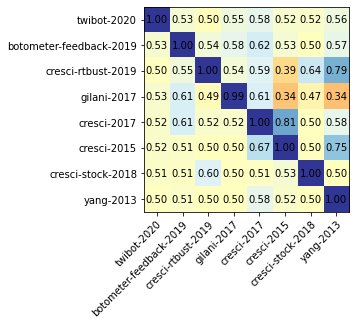

In [1333]:
depth=3
tootoa_a3 = heatmap_train_on_one_test_on_another(train_on_one_test_on_another_performance, 'accuracy', depth)
tootoa_a3.to_csv(f"tootoa_a{depth}.csv")

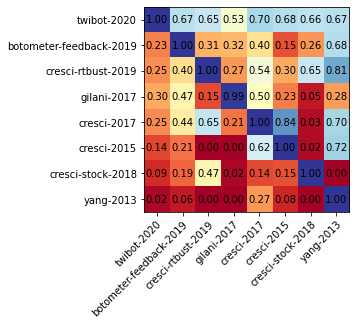

In [1326]:
depth=3
tootoa_f = heatmap_train_on_one_test_on_another(train_on_one_test_on_another_performance, 'f1', depth)
tootoa_f.to_csv(f"tootoa_f{depth}.csv")

# Leave-one-dataset-out

In [1068]:
cols = list(set.intersection(*map(set,[list(d) for d in datasets])))
max_depth = 5

rows = []

for i in range(len(datasets)):
    rows.append(leave_dataset_out(i))
    
leave_one_out_scores = pd.DataFrame(rows)

In [ ]:
plot_leave_one_out_scores()

In [1071]:
print_leave_one_out_table(leave_one_out_scores)

twibot-2020 & 0.45/0.18 & 1 \\
botometer-feedback-2019 & 0.65/0.40 & 1 \\
cresci-rtbust-2019 & 0.55/0.36 & 1 \\
gilani-2017 & 0.56/0.12 & 1 \\
cresci-2017 & 0.78/0.84 & 1 \\
cresci-2015 & 0.91/0.94 & 1 \\
cresci-stock-2018 & 0.65/0.66 & 1 \\
yang-2013 & 0.32/0.21 & 1 \\


## Analysis of each of the specialized classifiers in Botometer

In [635]:
def get_columns(df):
    return df.columns[~df.columns.str.contains('location') & ~df.columns.str.contains('utc') & ~df.columns.str.contains('time_zone')& ~df.columns.str.contains('lang')]


### humans

In [1244]:
caverlee_2011.set_axis(['created_at', 'friends_count', 'followers_count', 'statuses_count', 'LengthfScreenName', 'LengthOfDescriptionInUserProfile'], inplace=True, axis=1)

caverlee2011_humans = caverlee_2011[caverlee_2011_labels.values == 0]
botometer_feedback_2019_one_hot_humans = botometer_feedback_2019_one_hot[bf_labels.values == 0]
gilani_2017_one_hot_humans = gilani_2017_one_hot[gilani_labels.values == 0]
cresci_rtbust_2019_one_hot_humans = cresci_rtbust_2019_one_hot[rtbust_labels.values == 0]
cresci_stock_2018_one_hot_humans = cresci_stock_2018_one_hot[cresci_stock_labels.values == 0]
midterm_2018_one_hot_humans = midterm_2018_one_hot[midterm_labels.values == 0]

cols = set.intersection(
    set(celebrity_one_hot.columns),
    set(botometer_feedback_2019_one_hot_humans.columns),
    set(caverlee2011_humans.columns),
    set(gilani_2017_one_hot_humans.columns),
    set(cresci_stock_2018_one_hot_humans.columns),
                       )

human_df = pd.concat([
    caverlee2011_humans[cols], 
    botometer_feedback_2019_one_hot_humans[cols],
    celebrity_one_hot[cols],
    gilani_2017_one_hot_humans[cols],
    cresci_stock_2018_one_hot_humans[cols]
], axis=0)

Starting train_test_fit_and_score_clf at 10/07/22 10:31:06
|--- followers_count <= 10066.50
|   |--- friends_count <= 0.50
|   |   |--- statuses_count <= 93.50
|   |   |   |--- weights: [139.00, 0.00, 1.00, 7.00, 1.00] class: 0
|   |   |--- statuses_count >  93.50
|   |   |   |--- weights: [227.00, 1.00, 1.00, 10.00, 1485.00] class: 5
|   |--- friends_count >  0.50
|   |   |--- statuses_count <= 9199.50
|   |   |   |--- weights: [14176.00, 169.00, 111.00, 84.00, 2075.00] class: 0
|   |   |--- statuses_count >  9199.50
|   |   |   |--- weights: [829.00, 66.00, 24.00, 323.00, 1278.00] class: 5
|--- followers_count >  10066.50
|   |--- followers_count <= 207887.50
|   |   |--- statuses_count <= 17930.50
|   |   |   |--- weights: [72.00, 19.00, 623.00, 131.00, 18.00] class: 2
|   |   |--- statuses_count >  17930.50
|   |   |   |--- weights: [10.00, 21.00, 181.00, 231.00, 75.00] class: 4
|   |--- followers_count >  207887.50
|   |   |--- statuses_count <= 10220.50
|   |   |   |--- weights: 

(0.8064224332881049, -1, -1, -1)

In [ ]:
human_dataset_class_labels = [0] * len(caverlee2011_humans) \
        + [1] * len(botometer_feedback_2019_one_hot_humans) \
        + [2] * len(celebrity_one_hot) \
        + [4] * len(gilani_2017_one_hot_humans) \
        + [5] * len(cresci_stock_2018_one_hot_humans) 

train_test_fit_and_score(human_df.drop(['created_at'], axis=1), human_dataset_class_labels, depth=3, silent=False, prec_rec=False)

In [1247]:
n_accts = min(len(caverlee2011_humans), len(botometer_feedback_2019_one_hot_humans), len(celebrity_one_hot), len(gilani_2017_one_hot_humans), len(cresci_stock_2018_one_hot_humans))

human_df = pd.concat([
    caverlee2011_humans.sample(n_accts)[cols], 
    botometer_feedback_2019_one_hot_humans.sample(n_accts)[cols],
    celebrity_one_hot.sample(n_accts)[cols],
    gilani_2017_one_hot_humans.sample(n_accts)[cols],
    cresci_stock_2018_one_hot_humans.sample(n_accts)[cols]
], axis=0)

human_dataset_class_labels = [0] * n_accts \
        + [1] * n_accts \
        + [2] * n_accts \
        + [4] * n_accts \
        + [5] * n_accts 

train_test_fit_and_score(human_df.drop(['created_at'], axis=1), human_dataset_class_labels, depth=4, silent=False, prec_rec=False)


Starting train_test_fit_and_score_clf at 10/07/22 10:31:54
|--- followers_count <= 22243.00
|   |--- followers_count <= 729.50
|   |   |--- friends_count <= 0.50
|   |   |   |--- statuses_count <= 71.00
|   |   |   |   |--- weights: [2.00, 0.00, 0.00, 3.00, 0.00] class: 4
|   |   |   |--- statuses_count >  71.00
|   |   |   |   |--- weights: [6.00, 0.00, 0.00, 0.00, 84.00] class: 5
|   |   |--- friends_count >  0.50
|   |   |   |--- friends_count <= 165.00
|   |   |   |   |--- weights: [204.00, 53.00, 0.00, 3.00, 50.00] class: 0
|   |   |   |--- friends_count >  165.00
|   |   |   |   |--- weights: [64.00, 106.00, 1.00, 3.00, 98.00] class: 1
|   |--- followers_count >  729.50
|   |   |--- followers_count <= 2602.00
|   |   |   |--- statuses_count <= 20062.00
|   |   |   |   |--- weights: [25.00, 28.00, 3.00, 24.00, 20.00] class: 1
|   |   |   |--- statuses_count >  20062.00
|   |   |   |   |--- weights: [4.00, 16.00, 1.00, 90.00, 19.00] class: 4
|   |   |--- followers_count >  2602.00


(0.5815789473684211, -1, -1, -1)

### simple bots

In [637]:
caverlee2011_bots = caverlee_2011[caverlee_2011_labels.values == 1]
simple_df = caverlee2011_bots

In [638]:
simple_df.columns

Index(['created_at', 'friends_count', 'followers_count', 'statuses_count',
       'LengthfScreenName', 'LengthOfDescriptionInUserProfile'],
      dtype='object')

### spammers

In [1248]:
# Load in cresci data
folder_names = [ 'social_spambots_1', 
 'social_spambots_2', 
 'social_spambots_3', 
 'traditional_spambots_1', 
 'traditional_spambots_2', 
 'traditional_spambots_3',
 'traditional_spambots_4']
is_bot = [1, 1, 1, 1, 1, 1, 1]
cols_to_drop = COLUMNS_TO_DROP + ['profile_banner_url', 
                                        'test_set_1', 
                                        'test_set_2', 
                                        'crawled_at',
                                        'updated', 
                                        'timestamp',
                                        'following', 
                                        'follow_request_sent',
                                        'created_at',
                                  ]
dummy_cols = DUMMY_COLUMNS + ['is_translator', 'contributors_enabled', 'notifications']
    
cresci2017_spammers, cresci2017_spammers_one_hot, cresci2017_spammers_labels  = load_cresci(PROJ_PATH + "/data/cresci-2017/{}.csv/users.csv", folder_names, is_bot, cols_to_drop, dummy_cols, False)
# cresci2017_spammers_one_hot.loc[:,~cresci2017_spammers_one_hot.columns.duplicated()]
# pronbots_one_hot = pronbots_one_hot.loc[:,~pronbots_one_hot.columns.duplicated()]
# pronbots_one_hot = pronbots_one_hot.drop(['location'])
cols = set(pronbots_one_hot.columns).intersection(set(cresci2017_spammers_one_hot.columns))
spammers_df = pd.concat([pronbots_one_hot[cols], cresci2017_spammers_one_hot[cols]])


In [1249]:
from functools import reduce
list(reduce(lambda x,y: x + y, [[1, 1], [0, 0]]))

[1, 1, 0, 0]

In [1250]:
folder_names = [ 'social_spambots_1', 
 'social_spambots_2', 
 'social_spambots_3', 
 'traditional_spambots_1', 
 'traditional_spambots_2', 
 'traditional_spambots_3',
 'traditional_spambots_4']
labels = [0, 1, 2, 3, 4, 5, 6]
cols_to_drop = COLUMNS_TO_DROP + ['profile_banner_url', 
                                        'test_set_1', 
                                        'test_set_2', 
                                        'crawled_at',
                                        'updated', 
                                        'timestamp',
                                        'following', 
                                        'follow_request_sent',
                                        'created_at',
                                  ]
dummy_cols = DUMMY_COLUMNS + ['is_translator', 'contributors_enabled', 'notifications']
   
importlib.reload(sys.modules['data_accessor'])
cresci2017_spammers, cresci2017_spammers_one_hot, cresci2017_spammers_labels  = load_cresci(PROJ_PATH + "/data/cresci-2017/{}.csv/users.csv", folder_names, labels, cols_to_drop, dummy_cols, False)
cols = set(pronbots_one_hot.columns).intersection(set(cresci2017_spammers_one_hot.columns))

spammers_one_hot = pd.concat([cresci2017_spammers_one_hot[cols], pronbots_one_hot[cols]])
spammers_labels = pd.concat([cresci2017_spammers_labels, pd.Series([7]*len(pronbots_one_hot))])


train_test_fit_and_score(spammers_one_hot, spammers_labels, depth=4, silent=False, prec_rec=False)


Starting train_test_fit_and_score_clf at 10/07/22 10:32:27
|--- favourites_count <= 14.50
|   |--- followers_count <= 15.50
|   |   |--- friends_count <= 23.50
|   |   |   |--- time_zone_Athens <= 0.50
|   |   |   |   |--- weights: [1.00, 8.00, 1.00, 1.00, 0.00, 61.00, 0.00, 31.00] class: 5
|   |   |   |--- time_zone_Athens >  0.50
|   |   |   |   |--- weights: [305.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00] class: 0
|   |   |--- friends_count >  23.50
|   |   |   |--- statuses_count <= 97.50
|   |   |   |   |--- weights: [0.00, 2709.00, 1.00, 4.00, 0.00, 1.00, 0.00, 2.00] class: 1
|   |   |   |--- statuses_count >  97.50
|   |   |   |   |--- weights: [6.00, 4.00, 2.00, 0.00, 0.00, 8.00, 0.00, 0.00] class: 5
|   |--- followers_count >  15.50
|   |   |--- lang_en <= 0.50
|   |   |   |--- lang_it <= 0.50
|   |   |   |   |--- weights: [0.00, 0.00, 1.00, 786.00, 53.00, 0.00, 0.00, 10.00] class: 3
|   |   |   |--- lang_it >  0.50
|   |   |   |   |--- weights: [390.00, 0.00, 0.00, 0.00, 0

(0.9708947885939037, -1, -1, -1)

In [1252]:
folder_names = [ 'social_spambots_1', 
 'social_spambots_2', 
 'social_spambots_3', 
 'traditional_spambots_1', 
 'traditional_spambots_2', 
 'traditional_spambots_3',
 'traditional_spambots_4']
labels = [0, 1, 2, 3, 4, 5, 6]
cols_to_drop = COLUMNS_TO_DROP + ['profile_banner_url', 
                                        'test_set_1', 
                                        'test_set_2', 
                                        'crawled_at',
                                        'updated', 
                                        'timestamp',
                                        'following', 
                                        'follow_request_sent',
                                        'created_at',
                                  ]
dummy_cols = DUMMY_COLUMNS + ['is_translator', 'contributors_enabled', 'notifications']
   
importlib.reload(sys.modules['data_accessor'])
cresci2017_spammers, cresci2017_spammers_one_hot, cresci2017_spammers_labels  = load_cresci(PROJ_PATH + "/data/cresci-2017/{}.csv/users.csv", folder_names, labels, cols_to_drop, dummy_cols, False, balance=True)
cols = set(pronbots_one_hot.columns).intersection(set(cresci2017_spammers_one_hot.columns))

n_accts = sum(cresci2017_spammers_labels == 0)
spammers_one_hot = pd.concat([cresci2017_spammers_one_hot[cols], pronbots_one_hot[cols].sample(n_accts)])

spammers_labels = pd.concat([cresci2017_spammers_labels, pd.Series([7]*n_accts)])


train_test_fit_and_score(spammers_one_hot, spammers_labels, depth=4, silent=False, prec_rec=False)


Starting train_test_fit_and_score_clf at 10/07/22 10:32:34
|--- time_zone_Hawaii <= 0.50
|   |--- favourites_count <= 44.50
|   |   |--- lang_it <= 0.50
|   |   |   |--- friends_count <= 153.00
|   |   |   |   |--- weights: [1.00, 73.00, 3.00, 1.00, 0.00, 63.00, 0.00, 0.00] class: 1
|   |   |   |--- friends_count >  153.00
|   |   |   |   |--- weights: [7.00, 1.00, 75.00, 78.00, 1.00, 15.00, 79.00, 0.00] class: 6
|   |   |--- lang_it >  0.50
|   |   |   |--- weights: [69.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00] class: 0
|   |--- favourites_count >  44.50
|   |   |--- statuses_count <= 3986.50
|   |   |   |--- weights: [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 79.00] class: 7
|   |   |--- statuses_count >  3986.50
|   |   |   |--- friends_count <= 377.50
|   |   |   |   |--- weights: [0.00, 0.00, 0.00, 0.00, 0.00, 3.00, 0.00, 0.00] class: 5
|   |   |   |--- friends_count >  377.50
|   |   |   |   |--- weights: [0.00, 1.00, 3.00, 0.00, 0.00, 0.00, 0.00, 0.00] class: 2
|--- time_zon

(0.59375, -1, -1, -1)

In [640]:
get_columns(spammers_df)

Index(['friends_count', 'statuses_count', 'listed_count', 'followers_count',
       'favourites_count'],
      dtype='object')

### fake followers

In [1253]:
# Load in cresci data
folder_names = ['fake_followers']
is_bot = [1]
cols_to_drop = COLUMNS_TO_DROP + ['profile_banner_url',  
                                        'updated', 
                                        'following', 
                                        'follow_request_sent',
                                        'created_at'
                                  ]
dummy_cols = DUMMY_COLUMNS + ['is_translator', 'contributors_enabled', 'notifications']
    
cresci2017_fake_followers, cresci2017_fake_followers_one_hot, cresci2017_fake_followers_labels  = load_cresci(PROJ_PATH + "/data/cresci-2017/{}.csv/users.csv", folder_names, is_bot, cols_to_drop, dummy_cols, False)
cresci2017_fake_followers_one_hot = cresci2017_fake_followers_one_hot.loc[:,~cresci2017_fake_followers_one_hot.columns.duplicated()]
vendor_purchased_one_hot = vendor_purchased_one_hot.loc[:,~vendor_purchased_one_hot.columns.duplicated()]

cols = set(vendor_purchased_one_hot.columns).intersection(set(cresci2017_fake_followers_one_hot.columns))
fake_followers_df = pd.concat([vendor_purchased_one_hot, cresci2017_fake_followers_one_hot[cols]])


In [1254]:
fake_followers_df.columns[~fake_followers_df.columns.str.contains('location') & ~fake_followers_df.columns.str.contains('utc') & ~fake_followers_df.columns.str.contains('time_zone')& ~fake_followers_df.columns.str.contains('lang')]


Index(['followers_count', 'listed_count', 'statuses_count', 'friends_count',
       'favourites_count', 'created_at', 'default_profile_True',
       'default_profile_image_True', 'profile_background_tile_True',
       'geo_enabled_True', 'verified_True',
       'profile_use_background_image_True', 'is_translation_enabled_True',
       'has_extended_profile_True'],
      dtype='object')

In [1255]:
# Load in cresci data
folder_names = ['fake_followers']
is_bot = [1]
cols_to_drop = COLUMNS_TO_DROP + ['profile_banner_url',  
                                        'updated', 
                                        'following', 
                                        'follow_request_sent',
                                        'created_at'
                                  ]
dummy_cols = DUMMY_COLUMNS + ['is_translator', 'contributors_enabled', 'notifications']
    
cresci2017_fake_followers, cresci2017_fake_followers_one_hot, cresci2017_fake_followers_labels  = load_cresci(PROJ_PATH + "/data/cresci-2017/{}.csv/users.csv", folder_names, is_bot, cols_to_drop, dummy_cols, False)
cresci2017_fake_followers_one_hot = cresci2017_fake_followers_one_hot.loc[:,~cresci2017_fake_followers_one_hot.columns.duplicated()]
vendor_purchased_one_hot = vendor_purchased_one_hot.loc[:,~vendor_purchased_one_hot.columns.duplicated()]

cols = set(vendor_purchased_one_hot.columns).intersection(set(cresci2017_fake_followers_one_hot.columns))

fake_followers_df = pd.concat([vendor_purchased_one_hot[cols], cresci2017_fake_followers_one_hot[cols]])
fake_followers_labels = [0] * len(vendor_purchased_one_hot) + [1] * len(cresci2017_fake_followers_one_hot)

train_test_fit_and_score(fake_followers_df, fake_followers_labels, depth=1, silent=False, prec_rec=False)


Starting train_test_fit_and_score_clf at 10/07/22 10:33:02
|--- favourites_count <= 4.50
|   |--- weights: [54.00, 2580.00] class: 1
|--- favourites_count >  4.50
|   |--- weights: [805.00, 111.00] class: 0

Accuracy: 0.9493243243243243
Precision -1
Recall: -1
F1: -1
Finished train_test_fit_and_score_clf at 1665153182.7489762. Execution time: 0.03706836700439453 s


(0.9493243243243243, -1, -1, -1)

In [1256]:
# Load in cresci data
folder_names = ['fake_followers']
is_bot = [1]
cols_to_drop = COLUMNS_TO_DROP + ['profile_banner_url',  
                                        'updated', 
                                        'following', 
                                        'follow_request_sent',
                                        'created_at'
                                  ]
dummy_cols = DUMMY_COLUMNS + ['is_translator', 'contributors_enabled', 'notifications']
    
cresci2017_fake_followers, cresci2017_fake_followers_one_hot, cresci2017_fake_followers_labels  = load_cresci(PROJ_PATH + "/data/cresci-2017/{}.csv/users.csv", folder_names, is_bot, cols_to_drop, dummy_cols, False)
cresci2017_fake_followers_one_hot = cresci2017_fake_followers_one_hot.loc[:,~cresci2017_fake_followers_one_hot.columns.duplicated()]
vendor_purchased_one_hot = vendor_purchased_one_hot.loc[:,~vendor_purchased_one_hot.columns.duplicated()]

cols = set(vendor_purchased_one_hot.columns).intersection(set(cresci2017_fake_followers_one_hot.columns))

n_accts = min(len(vendor_purchased_one_hot), len(cresci2017_fake_followers_one_hot))

fake_followers_df = pd.concat([vendor_purchased_one_hot[cols].sample(n_accts), cresci2017_fake_followers_one_hot[cols].sample(n_accts)])
fake_followers_labels = [0] * n_accts + [1] * n_accts

train_test_fit_and_score(fake_followers_df, fake_followers_labels, depth=1, silent=False, prec_rec=False)


Starting train_test_fit_and_score_clf at 10/07/22 10:33:07
|--- favourites_count <= 2.50
|   |--- weights: [40.00, 830.00] class: 1
|--- favourites_count >  2.50
|   |--- weights: [831.00, 38.00] class: 0

Accuracy: 0.9425287356321839
Precision -1
Recall: -1
F1: -1
Finished train_test_fit_and_score_clf at 1665153187.0904372. Execution time: 0.029121875762939453 s


(0.9425287356321839, -1, -1, -1)

### self-declared

In [643]:
self_declared_df = botwiki_one_hot

get_columns(self_declared_df)

Index(['followers_count', 'friends_count', 'listed_count', 'created_at',
       'favourites_count', 'statuses_count', 'default_profile_True',
       'default_profile_image_True', 'default_profile_True',
       'default_profile_image_True', 'profile_background_tile_True',
       'geo_enabled_True', 'verified_True',
       'profile_use_background_image_True', 'is_translation_enabled_True',
       'has_extended_profile_True'],
      dtype='object')

### political bots

In [644]:
political_bots_df = political_bots_one_hot

get_columns(political_bots_df)

Index(['followers_count', 'listed_count', 'statuses_count', 'friends_count',
       'favourites_count', 'created_at', 'default_profile_True',
       'default_profile_True', 'profile_background_tile_True',
       'geo_enabled_True'],
      dtype='object')

### other bots

In [645]:
botometer_feedback_2019_one_hot_bot = botometer_feedback_2019_one_hot[bf_labels.values == 1]
gilani_2017_one_hot_bot = gilani_2017_one_hot[gilani_labels.values == 1]
cresci_rtbust_2019_one_hot_bot = cresci_rtbust_2019_one_hot[rtbust_labels.values == 1]
cresci_stock_2018_one_hot_bot = cresci_stock_2018_one_hot[cresci_stock_labels.values == 1]
midterm_2018_one_hot_bot = midterm_2018_one_hot[midterm_labels.values == 1]

cols = set.intersection(
    set(botometer_feedback_2019_one_hot_bot.columns), 
    set(gilani_2017_one_hot_bot.columns), 
    set(cresci_rtbust_2019_one_hot_bot.columns), 
    set(cresci_stock_2018_one_hot_bot.columns), 
)

other_bots = pd.concat([botometer_feedback_2019_one_hot_bot[cols], 
                        gilani_2017_one_hot_bot[cols], 
                        cresci_rtbust_2019_one_hot_bot[cols], 
                        cresci_stock_2018_one_hot_bot[cols]])


In [646]:
get_columns(other_bots)

Index(['default_profile_image_True', 'default_profile_image_True',
       'friends_count', 'listed_count', 'verified_True',
       'is_translation_enabled_True', 'has_extended_profile_True',
       'created_at', 'followers_count', 'profile_use_background_image_True',
       'default_profile_True', 'default_profile_True', 'statuses_count',
       'geo_enabled_True', 'favourites_count', 'profile_background_tile_True'],
      dtype='object')

In [1230]:
other_bots_labels = [0]*len(botometer_feedback_2019_one_hot_bot) + [1]*len(gilani_2017_one_hot_bot) + [2]*len(cresci_rtbust_2019_one_hot_bot) + [3]*len(cresci_stock_2018_one_hot_bot)

train_test_fit_and_score(other_bots, other_bots_labels, depth=3, silent=False, prec_rec=False)



Starting train_test_fit_and_score_clf at 10/06/22 21:04:28
|--- followers_count <= 701.50
|   |--- lang_it <= 0.50
|   |   |--- created_at <= 1505079680.00
|   |   |   |--- weights: [38.00, 20.00, 8.00, 5469.00] class: 3
|   |   |--- created_at >  1505079680.00
|   |   |   |--- weights: [5.00, 5.00, 20.00, 0.00] class: 2
|   |--- lang_it >  0.50
|   |   |--- created_at <= 1350975616.00
|   |   |   |--- weights: [0.00, 0.00, 27.00, 29.00] class: 3
|   |   |--- created_at >  1350975616.00
|   |   |   |--- weights: [0.00, 0.00, 190.00, 10.00] class: 2
|--- followers_count >  701.50
|   |--- followers_count <= 27269.00
|   |   |--- favourites_count <= 1555.00
|   |   |   |--- weights: [25.00, 178.00, 2.00, 16.00] class: 1
|   |   |--- favourites_count >  1555.00
|   |   |   |--- weights: [31.00, 119.00, 34.00, 150.00] class: 3
|   |--- followers_count >  27269.00
|   |   |--- created_at <= 1444555456.00
|   |   |   |--- weights: [15.00, 547.00, 1.00, 1.00] class: 1
|   |   |--- created_at 

(0.9510650546919976, -1, -1, -1)

In [1234]:
n_accts = min(len(botometer_feedback_2019_one_hot_bot), len(gilani_2017_one_hot_bot), len(cresci_rtbust_2019_one_hot_bot), len(cresci_stock_2018_one_hot_bot))

other_bots = pd.concat([botometer_feedback_2019_one_hot_bot[cols].sample(n_accts), 
                        gilani_2017_one_hot_bot[cols].sample(n_accts), 
                        cresci_rtbust_2019_one_hot_bot[cols].sample(n_accts), 
                        cresci_stock_2018_one_hot_bot[cols].sample(n_accts)])

other_bots_labels = [0]*n_accts + [1]*n_accts + [2]*n_accts + [3]*n_accts
train_test_fit_and_score(other_bots, other_bots_labels, depth=4, silent=False, prec_rec=False)


Starting train_test_fit_and_score_clf at 10/06/22 21:08:29
|--- followers_count <= 701.50
|   |--- created_at <= 1392233920.00
|   |   |--- statuses_count <= 98.00
|   |   |   |--- weights: [11.00, 0.00, 0.00, 0.00] class: 0
|   |   |--- statuses_count >  98.00
|   |   |   |--- followers_count <= 162.50
|   |   |   |   |--- weights: [2.00, 0.00, 2.00, 71.00] class: 3
|   |   |   |--- followers_count >  162.50
|   |   |   |   |--- weights: [5.00, 0.00, 11.00, 7.00] class: 2
|   |--- created_at >  1392233920.00
|   |   |--- statuses_count <= 358.50
|   |   |   |--- friends_count <= 30.50
|   |   |   |   |--- weights: [0.00, 0.00, 1.00, 13.00] class: 3
|   |   |   |--- friends_count >  30.50
|   |   |   |   |--- weights: [13.00, 0.00, 0.00, 0.00] class: 0
|   |   |--- statuses_count >  358.50
|   |   |   |--- statuses_count <= 25426.00
|   |   |   |   |--- weights: [7.00, 0.00, 80.00, 13.00] class: 2
|   |   |   |--- statuses_count >  25426.00
|   |   |   |   |--- weights: [5.00, 3.00, 1.

(0.7857142857142857, -1, -1, -1)

# Botometer combined datasets: train on one, test on same one

In [1336]:
botometer_datasets = [simple_df, spammers_df, fake_followers_df, self_declared_df, political_bots_df, other_bots]

rows = []
for j, dataset in enumerate(botometer_datasets[0:]):
    print(get_dataset_name(dataset))
    rows.append(train_test_botometer_combined(dataset, human_df, silent=False))
    
botometer_leave_one_out_scores = pd.DataFrame(rows)

caverlee2011_bots
Starting train_test_fit_and_score_clf at 10/07/22 14:09:45
|--- statuses_count <= 1351.50
|   |--- weights: [239.00, 666.00] class: 1
|--- statuses_count >  1351.50
|   |--- weights: [568.00, 127.00] class: 0

Accuracy: 0.78
Precision 0.7644444444444445
Recall: 0.8309178743961353
F1: 0.7962962962962963
Finished train_test_fit_and_score_clf at 1665166185.492984. Execution time: 0.04721832275390625 s
Starting train_test_fit_and_score_clf at 10/07/22 14:09:45
|--- statuses_count <= 1522.00
|   |--- friends_count <= 82.00
|   |   |--- weights: [143.00, 33.00] class: 0
|   |--- friends_count >  82.00
|   |   |--- weights: [108.00, 633.00] class: 1
|--- statuses_count >  1522.00
|   |--- statuses_count <= 7321.50
|   |   |--- weights: [193.00, 101.00] class: 0
|   |--- statuses_count >  7321.50
|   |   |--- weights: [374.00, 15.00] class: 0

Accuracy: 0.7975
Precision 0.8549222797927462
Recall: 0.7568807339449541
F1: 0.802919708029197
Finished train_test_fit_and_score_clf a

Accuracy: 0.8975
Precision 0.8755980861244019
Recall: 0.9242424242424242
F1: 0.8992628992628992
Finished train_test_fit_and_score_clf at 1665166185.6460164. Execution time: 0.02106189727783203 s
Starting train_test_fit_and_score_clf at 10/07/22 14:09:45
|--- statuses_count <= 221.50
|   |--- friends_count <= 0.50
|   |   |--- weights: [13.00, 428.00] class: 1
|   |--- friends_count >  0.50
|   |   |--- weights: [77.00, 279.00] class: 1
|--- statuses_count >  221.50
|   |--- friends_count <= 8.50
|   |   |--- weights: [44.00, 20.00] class: 0
|   |--- friends_count >  8.50
|   |   |--- weights: [691.00, 48.00] class: 0

Accuracy: 0.895
Precision 0.9140271493212669
Recall: 0.8977777777777778
F1: 0.9058295964125561
Finished train_test_fit_and_score_clf at 1665166185.6663723. Execution time: 0.020336151123046875 s
Starting train_test_fit_and_score_clf at 10/07/22 14:09:45
|--- statuses_count <= 205.50
|   |--- friends_count <= 0.50
|   |   |--- statuses_count <= 97.00
|   |   |   |--- weigh

|--- friends_count <= 20.50
|   |--- weights: [70.00, 478.00] class: 1
|--- friends_count >  20.50
|   |--- weights: [484.00, 84.00] class: 0

Accuracy: 0.8678571428571429
Precision 0.8721804511278195
Recall: 0.8529411764705882
F1: 0.862453531598513
Finished train_test_fit_and_score_clf at 1665166186.2426703. Execution time: 0.3987901210784912 s
Starting train_test_fit_and_score_clf at 10/07/22 14:09:46
|--- friends_count <= 19.50
|   |--- statuses_count <= 301.00
|   |   |--- weights: [35.00, 17.00] class: 0
|   |--- statuses_count >  301.00
|   |   |--- weights: [35.00, 452.00] class: 1
|--- friends_count >  19.50
|   |--- friends_count <= 59.50
|   |   |--- weights: [46.00, 41.00] class: 0
|   |--- friends_count >  59.50
|   |   |--- weights: [443.00, 47.00] class: 0

Accuracy: 0.9
Precision 0.937984496124031
Recall: 0.8581560283687943
F1: 0.8962962962962963
Finished train_test_fit_and_score_clf at 1665166186.2741556. Execution time: 0.031432390213012695 s
Starting train_test_fit_an

|--- followers_count <= 224483.00
|   |--- weights: [341.00, 404.00] class: 1
|--- followers_count >  224483.00
|   |--- weights: [110.00, 34.00] class: 0

Accuracy: 0.5695067264573991
Precision 0.5572916666666666
Recall: 0.9067796610169492
F1: 0.6903225806451613
Finished train_test_fit_and_score_clf at 1665166186.4441698. Execution time: 0.017094135284423828 s
Starting train_test_fit_and_score_clf at 10/07/22 14:09:46
|--- statuses_count <= 71602.50
|   |--- followers_count <= 34866.50
|   |   |--- weights: [271.00, 320.00] class: 1
|   |--- followers_count >  34866.50
|   |   |--- weights: [141.00, 36.00] class: 0
|--- statuses_count >  71602.50
|   |--- statuses_count <= 219663.50
|   |   |--- weights: [20.00, 68.00] class: 1
|   |--- statuses_count >  219663.50
|   |   |--- weights: [1.00, 32.00] class: 1

Accuracy: 0.5829596412556054
Precision 0.5193370165745856
Recall: 0.94
F1: 0.6690391459074733
Finished train_test_fit_and_score_clf at 1665166186.461613. Execution time: 0.017416

In [ ]:
plot_botometer_combined_dataset_performance()

# Botometer combined datasets: train on one, test on another

In [1339]:
rows = []

for bots1 in botometer_datasets:
    for bots2 in botometer_datasets:
        rows.append(train_on_one_test_on_another_botometer_combined(bots1, bots2, human_df, silent=True))
        
botometer_train_on_one_test_on_another_performance = pd.DataFrame(rows)   


/home/jhays/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jhays/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


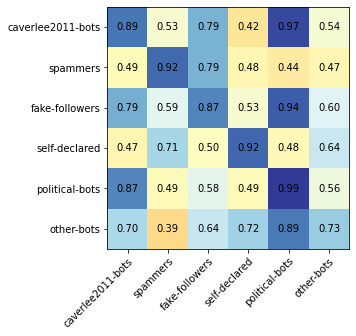

In [1341]:
depth = 3
botometer_tootoa_a = heatmap_train_on_one_test_on_another(botometer_train_on_one_test_on_another_performance, 'accuracy', depth)
botometer_tootoa_a.to_csv(f"botometer_tootoa_a{depth}.csv")

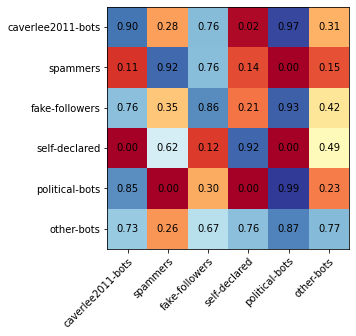

In [1342]:
depth = 3
botometer_tootoa_f = heatmap_train_on_one_test_on_another(botometer_train_on_one_test_on_another_performance, 'f1', depth)
botometer_tootoa_f.to_csv(f"botometer_tootoa_f{depth}.csv")

In [1343]:
botometer_tootoa_a

,caverlee2011_bots,spammers_df,fake_followers_df,self_declared_df,political_bots_df,other_bots
caverlee2011_bots,0.894211,0.531053,0.785789,0.419054,0.967742,0.535072
spammers_df,0.487105,0.916842,0.788158,0.475645,0.435484,0.473022
fake_followers_df,0.793947,0.585789,0.868421,0.527937,0.935484,0.597122
self_declared_df,0.469914,0.707020,0.503582,0.920487,0.483871,0.642086
political_bots_df,0.870968,0.491935,0.580645,0.491935,0.991935,0.556452
other_bots,0.696942,0.388489,0.644784,0.716727,0.887097,0.729317


# Botometer combined datasets: leave-one-dataset-out

In [655]:
cols = list(set.intersection(*map(set,[list(d) for d in botometer_datasets])))
if 'created_at' in cols:
    cols.remove("created_at")
max_depth = 5
n = 1000

rows = []

for i in range(len(botometer_datasets)):
    rows.append(botometer_leave_dataset_out(botometer_datasets, i))
    
botometer_leave_one_out_scores = pd.DataFrame(rows)

In [656]:
print_leave_one_out_table(botometer_leave_one_out_scores)

caverlee2011_bots & 0.70 \textit{(3)} & 0.70  \textit{(1)} \\
spammers_df & 0.81 \textit{(2)} & 0.81  \textit{(2)} \\
fake_followers_df & 0.92 \textit{(3)} & 0.92  \textit{(3)} \\
botwiki_one_hot & 0.46 \textit{(1)} & 0.46  \textit{(2)} \\
political_bots_df & 0.96 \textit{(3)} & 0.96  \textit{(3)} \\
other_bots & 0.51 \textit{(1)} & 0.51  \textit{(2)} \\


# Ensemble of specialized decision trees

In [1092]:
def split_human_df(human_df, n_datasets, dataset_size):
    human_df_sample = human_df.sample(n=n_datasets*dataset_size)
    return [human_df_sample[i*dataset_size:(i+1)*dataset_size] for i in range(n_datasets)]

In [1093]:
DEPTH = 4


In [1309]:
botometer_datasets = [simple_df, spammers_df, fake_followers_df, self_declared_df, political_bots_df, other_bots]
human_dfs = split_human_df(human_df, len(botometer_datasets), dataset_size)

cols = set.intersection(
    *[set(b.columns) for b in botometer_datasets],
    set(human_df.columns)
)
if 'created_at' in cols:
    cols.remove('created_at')
cols = list(cols)



ValueError: Cannot take a larger sample than population when 'replace=False'

In [1096]:
clfs, test_aggregate_df, test_labels_aggregate_concat = get_ensemble_of_classifiers()


In [1097]:
score_ensemble_speicalized_trees(clfs, test_aggregate_df, test_labels_aggregate_concat)

Accuracy using max confidences: 0.5693169092945128
Accuracy using majority vote: 0.792609182530795
Accuracy using weighted majority vote: 0.6512877939529675
F1 using max confidences: 0.2811214953271028
F1 using majority votes: 0.765093860984272
F1 using weighted majority votes: 0.4801335559265442
Accuracy using most captured: 0.8085106382978723
Accuracy using weighted most captured: 0.8085106382978723)
F1 using most captured: 0.8014859530996054
F1 using weighted majority captured: 0.8014859530996054


## Ensembles of specialized random forests

In [1098]:
:w
    rf = ensemble.RandomForestClassifier(n_estimators=100)
rf_clfs, test_aggregate_df, test_labels_aggregate_concat = get_ensemble_of_classifiers(rf)

predictions = [rf_clfs[i].predict(test_aggregate_df) for i in range(n_classifiers)]
probs = [rf_clfs[i].predict_proba(test_aggregate_df) for i in range(n_classifiers)]
probs = [p[:,0] for p in probs]
most_confident_clf = [get_max_confidence_rf(probs, i)[0] for i in range(len(test_aggregate_df))]
max_prediction = [predictions[j][i] for i,j in enumerate(most_confident_clf)]
print(f"Accuracy: {accuracy_score(max_prediction, test_labels_aggregate_concat)}")
print(f"F1: {f1_score(max_prediction, test_labels_aggregate_concat)}")

Accuracy: 0.5522956326987682
F1: 0.23085802231627547


## Just simple decision rule

In [1099]:
all_clf = clfs[-1]
all_predictions = all_clf.predict(test_aggregate_df)
print(f"Accuracy: {accuracy_score(all_predictions, test_labels_aggregate_concat)}")
print(f"F1: {f1_score(all_predictions, test_labels_aggregate_concat)}")

Accuracy: 0.8100783874580068
F1: 0.8108831400535237


## Just random forest

In [1100]:
all_clf_rf = rf_clfs[-1]
all_predictions_rf = all_clf_rf.predict(test_aggregate_df)
print(f"Accuracy: {accuracy_score(all_predictions_rf, test_labels_aggregate_concat)}")
print(f"F1: {f1_score(all_predictions_rf, test_labels_aggregate_concat)}")

Accuracy: 0.8855543113101904
F1: 0.8867715488588522


## Testing on held-out set

In [1101]:
hold_out_test_df = pd.concat([cresci_stock_2018_one_hot[cols], cresci_rtbust_2019_one_hot[cols], gilani_2017_one_hot[cols]])
hold_out_test_labels = pd.concat([cresci_stock_labels, rtbust_labels, gilani_labels])

score_ensemble_speicalized_trees(clfs, hold_out_test_df, hold_out_test_labels)


Accuracy using max confidences: 0.46229966002914036
Accuracy using majority vote: 0.5355755220981059
Accuracy using weighted majority vote: 0.46958474987858184
F1 using max confidences: 0.046917034326912736
F1 using majority votes: 0.4088098918083462
F1 using weighted majority votes: 0.0606386410063434
Accuracy using most captured: 0.4993929091792132
Accuracy using weighted most captured: 0.49945361826129187)
F1 using most captured: 0.445609788893371
F1 using weighted majority captured: 0.4456397498823372


In [1106]:
score_ensemble_speicalized_trees(clfs, cresci_stock_2018_one_hot[cols], cresci_stock_labels)

Accuracy using max confidences: 0.44448629105152154
Accuracy using majority vote: 0.5284724314552576
Accuracy using weighted majority vote: 0.4517173847544441
F1 using max confidences: 0.04033832140533506
F1 using majority votes: 0.43684778697373156
F1 using weighted majority votes: 0.06547695467967646
Accuracy using most captured: 0.491563724013257
Accuracy using weighted most captured: 0.491563724013257)
F1 using most captured: 0.4731501717140181
F1 using weighted majority captured: 0.4731501717140181


In [1107]:
score_ensemble_speicalized_trees(clfs, cresci_rtbust_2019_one_hot[cols], rtbust_labels)

Accuracy using max confidences: 0.44155844155844154
Accuracy using majority vote: 0.46176046176046176
Accuracy using weighted majority vote: 0.47474747474747475
F1 using max confidences: 0.05839416058394161
F1 using majority votes: 0.15419501133786848
F1 using weighted majority votes: 0.037037037037037035
Accuracy using most captured: 0.4227994227994228
Accuracy using weighted most captured: 0.4227994227994228)
F1 using most captured: 0.22779922779922782
F1 using weighted majority captured: 0.22779922779922782


In [1104]:
score_ensemble_speicalized_trees(clfs, gilani_2017_one_hot[cols], gilani_labels)

Accuracy using max confidences: 0.5625249700359568
Accuracy using majority vote: 0.5936875749101078
Accuracy using weighted majority vote: 0.5629244906112665
F1 using max confidences: 0.08521303258145364
F1 using majority votes: 0.2646420824295011
F1 using weighted majority votes: 0.03527336860670194
Accuracy using most captured: 0.5621254494606472
Accuracy using weighted most captured: 0.5625249700359568)
F1 using most captured: 0.2901554404145078
F1 using weighted majority captured: 0.29034348671419313


In [1105]:
all_predictions = all_clf.predict(hold_out_test_df)
print(f"Accuracy: {accuracy_score(all_predictions, hold_out_test_labels)}")
print(f"F1: {f1_score(all_predictions, hold_out_test_labels)}")

Accuracy: 0.5064958717824186
F1: 0.4619763055132703


In [1108]:
all_predictions = all_clf.predict(cresci_stock_2018_one_hot[cols])
print(f"Accuracy: {accuracy_score(all_predictions, cresci_stock_labels)}")
print(f"F1: {f1_score(all_predictions, cresci_stock_labels)}")

Accuracy: 0.4909611328713468
F1: 0.4729371392918421


In [1112]:
all_predictions = all_clf.predict(cresci_rtbust_2019_one_hot[cols])
print(f"Accuracy: {accuracy_score(all_predictions, rtbust_labels)}")
print(f"F1: {f1_score(all_predictions, rtbust_labels)}")

Accuracy: 0.4213564213564214
F1: 0.2273603082851638


In [1109]:
all_predictions = all_clf.predict(gilani_2017_one_hot[cols])
print(f"Accuracy: {accuracy_score(all_predictions, gilani_labels)}")
print(f"F1: {f1_score(all_predictions, gilani_labels)}")

Accuracy: 0.6124650419496604
F1: 0.4513574660633484


In [1110]:
all_clf_rf = rf_clfs[-1]
all_predictions_rf = all_clf_rf.predict(hold_out_test_df)
print(f"Accuracy: {accuracy_score(all_predictions_rf, hold_out_test_labels)}")
print(f"F1: {f1_score(all_predictions_rf, hold_out_test_labels)}")

Accuracy: 0.8944269062651773
F1: 0.8897902275175866


In [1111]:
all_predictions_rf = all_clf_rf.predict(cresci_stock_2018_one_hot[cols])
print(f"Accuracy: {accuracy_score(all_predictions_rf, cresci_stock_labels)}")
print(f"F1: {f1_score(all_predictions_rf, cresci_stock_labels)}")

Accuracy: 0.9026062066887617
F1: 0.9022749603204596


In [1113]:
all_predictions_rf = all_clf_rf.predict(cresci_rtbust_2019_one_hot[cols])
print(f"Accuracy: {accuracy_score(all_predictions_rf, rtbust_labels)}")
print(f"F1: {f1_score(all_predictions_rf, rtbust_labels)}")

Accuracy: 0.7878787878787878
F1: 0.7741935483870966


In [1114]:
all_predictions_rf = all_clf_rf.predict(gilani_2017_one_hot[cols])
print(f"Accuracy: {accuracy_score(all_predictions_rf, gilani_labels)}")
print(f"F1: {f1_score(all_predictions_rf, gilani_labels)}")

Accuracy: 0.8805433479824211
F1: 0.8423827095413812
